Две необходимых ссылки
https://pysindy.readthedocs.io/en/latest/examples/index.html

https://pysindy.readthedocs.io/en/latest/examples/2_introduction_to_sindy/example.html

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, UnivariateSpline, LSQUnivariateSpline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import torch 


import pysindy as ps

# Генерация данных как в CRNN-модели

## Функция для вычисления приращений концентраций веществ

In [112]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [113]:
N_REACTION = 4                                                       # кол-во реакций
N_SUBSTANCE = 5                                                      # кол-во веществ
VR_TIME = 40                                                         # время протекания реакций
INIT_CONC = np.array([1.0, 0.5, 0.1, 0.4, 0])                          # начальные концентрации веществ
k = torch.tensor([0.2, 0.1, 0.13, 0.3], dtype=torch.float32)         # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(0, VR_TIME, VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

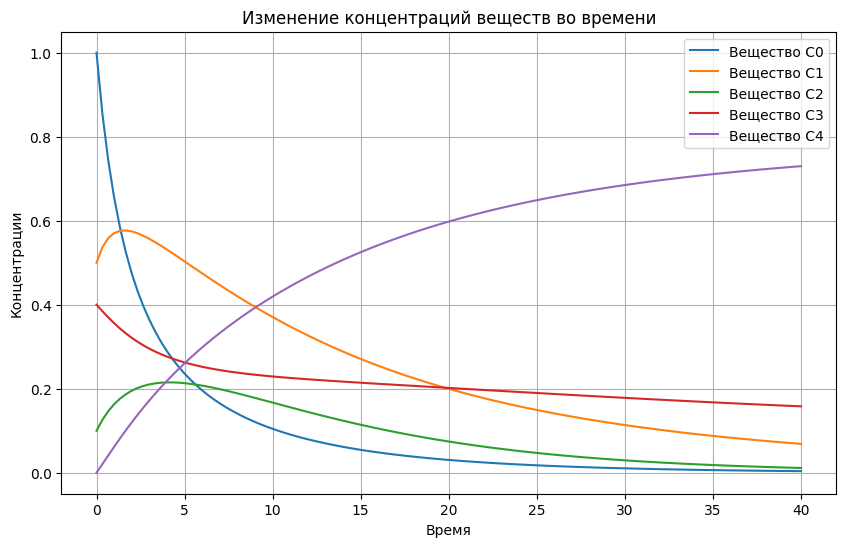

Начальные концентрации:        [1.  0.5 0.1 0.4 0. ]
Сумма концентраций веществ:    2.0
Концентрации после 40 секунд:  [0.06992659 0.30691207 0.13402883 0.21963841 0.48752735]
Сумма концентрций веществ:     1.21803324857856


In [114]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()

print("Начальные концентрации:       ", INIT_CONC)
print("Сумма концентраций веществ:   ", sum(INIT_CONC))
print(f"Концентрации после {VR_TIME} секунд:  {sol.y[:, VR_TIME - 1]}")
print("Сумма концентрций веществ:    ", sum(sol.y[:, VR_TIME - 1]))

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Вычисление приращений концентраций со временем (прямая задача)

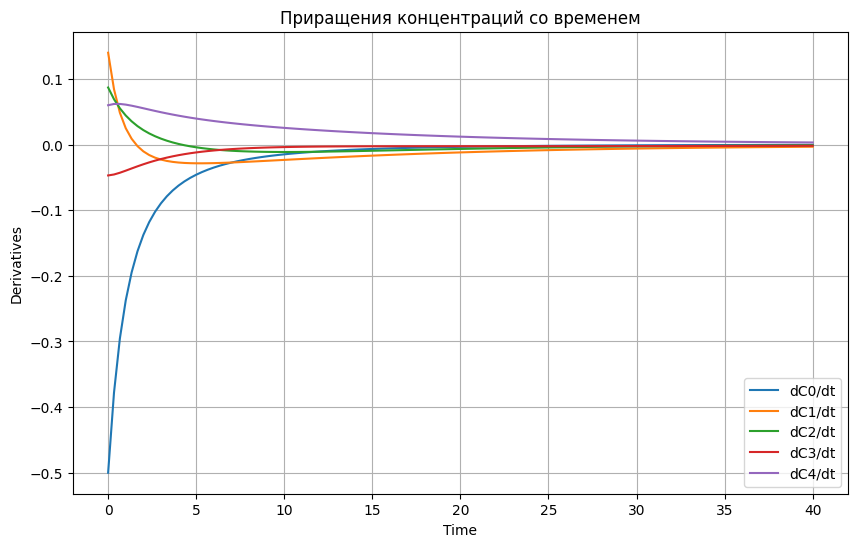

In [115]:
dCdt_TRUE = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # Приращения по истинным концентрациям C

plt.figure(figsize=(10, 6))
for i in range(dCdt_TRUE.shape[0]):
    plt.plot(sol.t, dCdt_TRUE[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

# Добавление шума

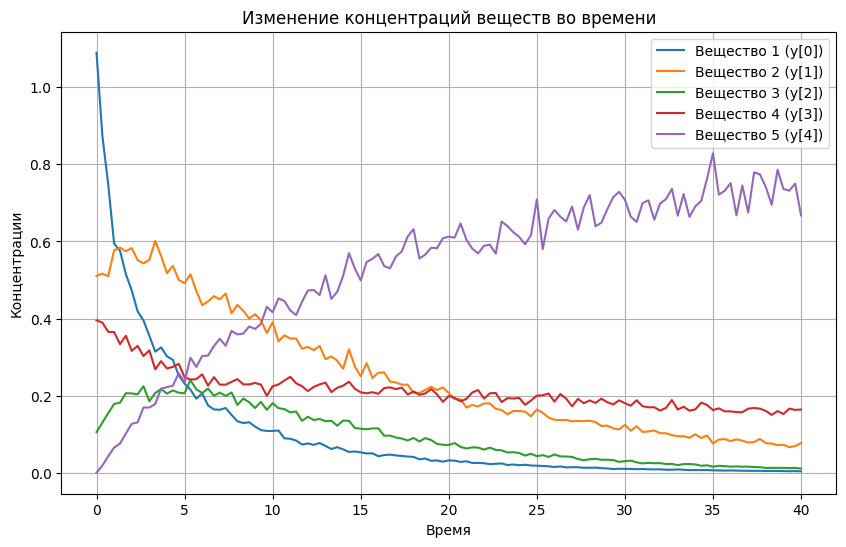

In [116]:
# Генерация шума
noise_level = 5e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
np.random.seed(3)

noise = np.random.normal(0, noise_level * np.abs(y_noisy))          #
y_noisy += noise                                                    #

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество {i+1} (y[{i}])')

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


# Построение полиномиальных аппроксимаций функций изменения концентраций

Вещество C0: R^2 = 0.995778
Свободный коэффициент: 1.031287
Коэффициенты полинома, начиная с x^1:
-0.4747768380, 0.1286885021, -0.0204634487, 0.0019533060, -0.0001150108, 0.0000042037, -0.0000000928, 0.0000000011, -0.0000000000

Вещество C1: R^2 = 0.993919
Свободный коэффициент: 0.497967
Коэффициенты полинома, начиная с x^1:
0.0938933968, -0.0386790834, 0.0062086686, -0.0005715429, 0.0000322566, -0.0000011301, 0.0000000239, -0.0000000003, 0.0000000000

Вещество C2: R^2 = 0.991651
Свободный коэффициент: 0.111611
Коэффициенты полинома, начиная с x^1:
0.0755992154, -0.0205394085, 0.0028914950, -0.0002584792, 0.0000148101, -0.0000005359, 0.0000000118, -0.0000000001, 0.0000000000

Вещество C3: R^2 = 0.965500
Свободный коэффициент: 0.392615
Коэффициенты полинома, начиная с x^1:
-0.0258067358, -0.0063950712, 0.0021750866, -0.0002602559, 0.0000165884, -0.0000006177, 0.0000000135, -0.0000000002, 0.0000000000

Вещество C4: R^2 = 0.979519
Свободный коэффициент: 0.005922
Коэффициенты полинома, нач

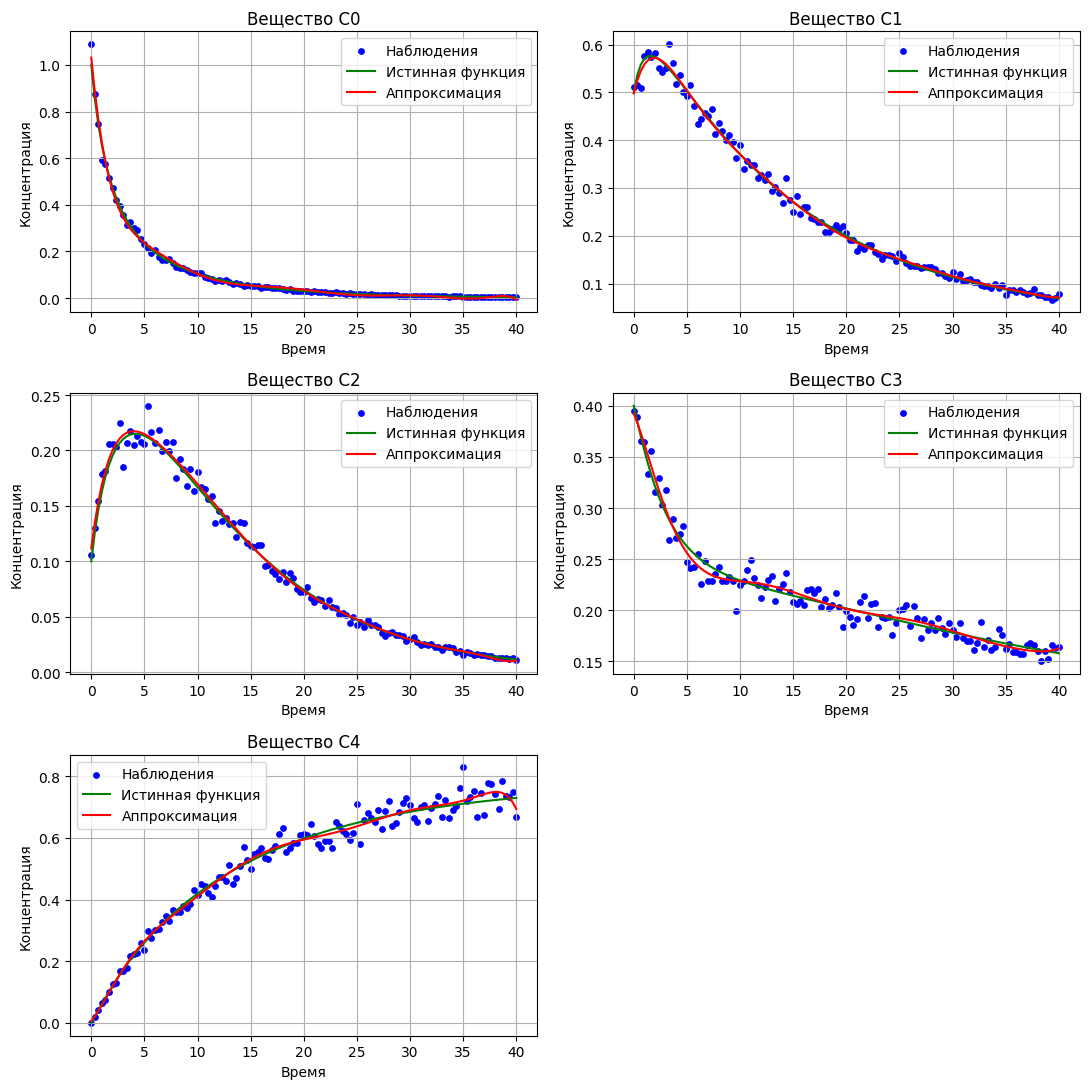

In [117]:
# Преобразование признаков в полиномиальные
poly_degree = 9
poly = PolynomialFeatures(degree=poly_degree)
time_vec = sol.t.reshape(-1, 1)         # Изменение формата временного шага для метода из sklearn
t_poly = poly.fit_transform(time_vec)

# Определяем количество строк и столбцов для сетки графиков
rows, cols = (3, 2)  # Подходит для N_SUBSTANCE = 6
fig, axes = plt.subplots(rows, cols, figsize=(11, 11), squeeze=False)   # Размер общего окна

# Массив для коэффициентов полиномов
reaction_poly_coeffs = np.zeros((N_SUBSTANCE, poly_degree + 1))  # Массив из 5 строк и 9 столбцов. Тут будут храниться коэффициенты полиномов 
                                                   # Столбцы - число коэффициентов полинома, строки - концентрации веществ

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    model = LinearRegression()
    model.fit(t_poly, y)
    y_pred = model.predict(t_poly)

    # Определяем текущую ось
    ax = axes[i // cols, i % cols]
    
    # Строим график
    ax.scatter(time_vec, y, color='blue', label='Наблюдения', s=15)
    ax.plot(sol.t, CONC_TRUE[i], color='green', label='Истинная функция')
    ax.plot(time_vec, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    ax.set_title(f'Вещество C{i}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Концентрация')
    ax.legend()
    ax.grid()

    # Сохранение коэффициентов полинома
    reaction_poly_coeffs[i, 0] = model.intercept_
    reaction_poly_coeffs[i, 1:] = model.coef_[1:]  # Пропускаем свободный член
    
    # Вывод коэффициентов
    r2 = model.score(t_poly, y)
    print(f"Вещество C{i}: R^2 = {r2:.6f}")
    print(f"Свободный коэффициент: {model.intercept_:.6f}")
    print("Коэффициенты полинома, начиная с x^1:")
    print(f"{', '.join(f'{coef:.10f}' for coef in model.coef_[1:])}\n")

# Убираем пустые графики
for j in range(N_SUBSTANCE, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


Здесь первый элемент `model.coef_[0]` = `0.00000000e+00` соответствует \(x^0\). Он, равен `0`, так как свободный член отдельно хранится в `model.intercept_`.

# Аппроксимация с использованием Сплайнов

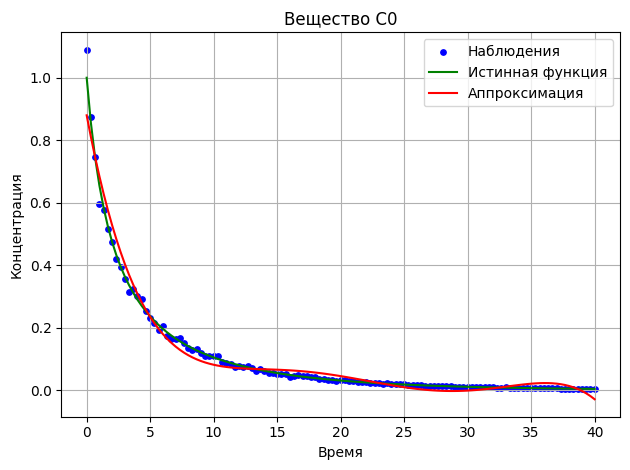

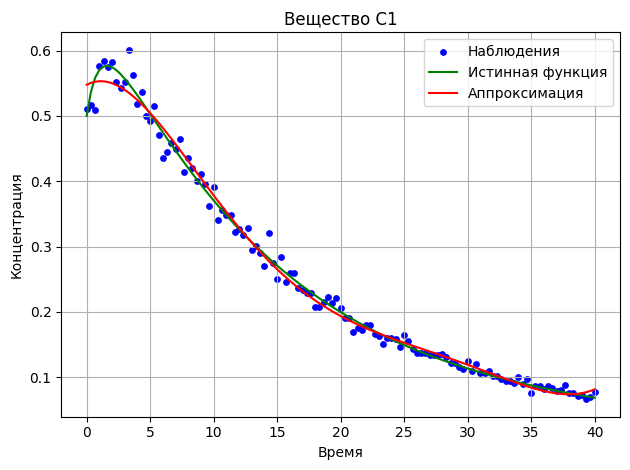

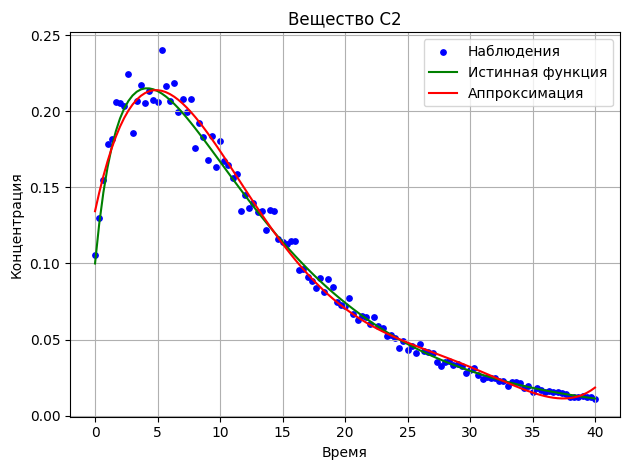

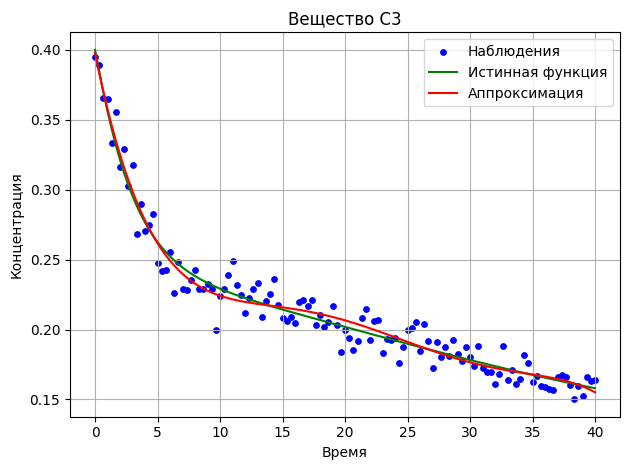

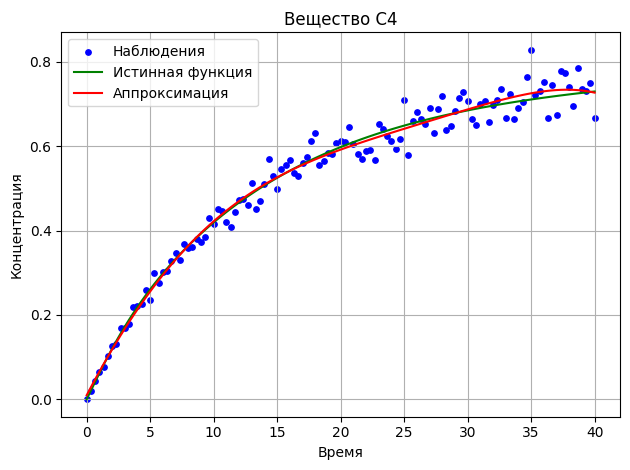

In [118]:
splines = []  # Список для хранения моделей

# Создаем плотную сетку для отображения сплайна
x_dense = np.linspace(0, VR_TIME, len(tsteps) * 1)

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline = UnivariateSpline(tsteps, y, k=5, s=1)
    splines.append(spline)  # Сохраняем модель

    y_pred = spline(x_dense)
    # y_pred = spline(tsteps)

    # Строим график
    plt.scatter(tsteps, y, color='blue', label='Наблюдения', s=15)
    plt.plot(tsteps, CONC_TRUE[i], color='green', label='Истинная функция')
    plt.plot(x_dense, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    plt.title(f'Вещество C{i}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Вывод коэффициентов
    # r2 = r2_score(CONC_TRUE[i], y_pred)
    # print(f"Вещество C{i}: R^2 = {r2:.6f}")


# Сплайны с настройкой узлов

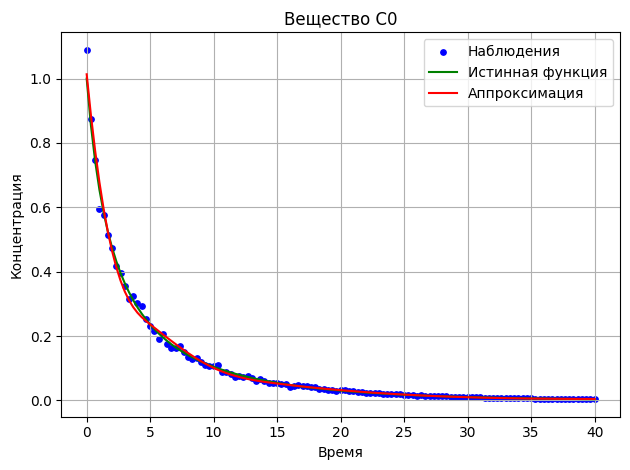

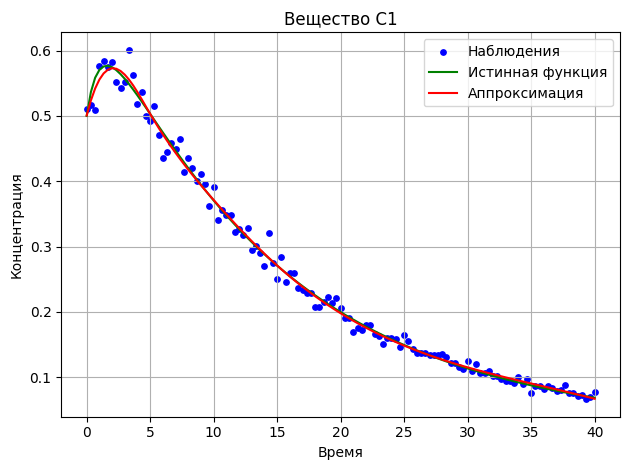

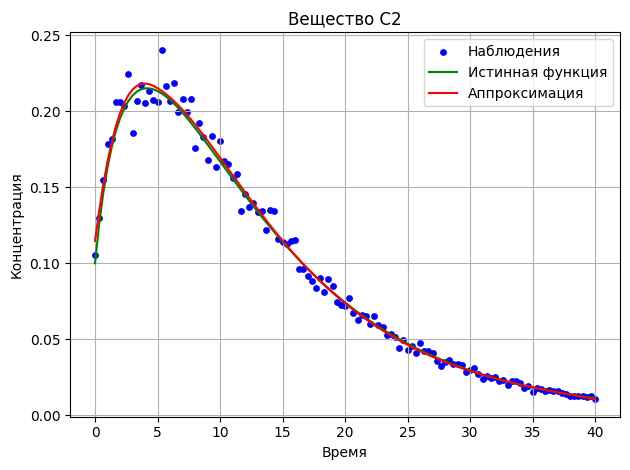

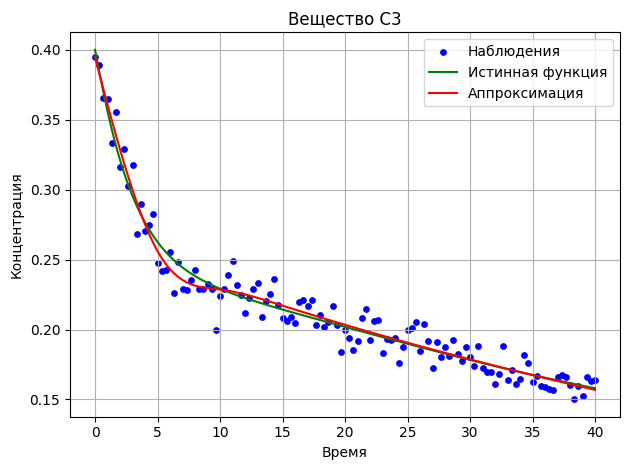

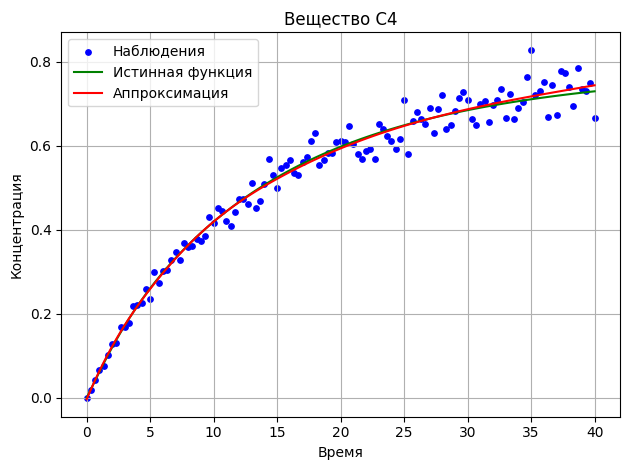

In [119]:
splines_2 = []  # Список для хранения моделей

# Создаем плотную сетку для отображения сплайна
x_dense = np.linspace(0, VR_TIME, len(tsteps) * 1)

# Явное задание узлов разбиения
knots = np.linspace(0, VR_TIME, 7)          
knots = np.delete(knots, [0, -1])           # Узлы должны быть внутри диапазона x, не должны содержать концов

knots_smart = [5., 10., 15.]                # Сделал меньше промежутки в начале, где происходят интенсивные изменения

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline_2 = LSQUnivariateSpline(tsteps, y, knots_smart, k=3)
    splines_2.append(spline_2)  # Сохраняем модель

    y_pred = spline_2(x_dense)
    # y_pred = spline(tsteps)

    # Строим график
    plt.scatter(tsteps, y, color='blue', label='Наблюдения', s=15)
    plt.plot(tsteps, CONC_TRUE[i], color='green', label='Истинная функция')
    plt.plot(x_dense, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    plt.title(f'Вещество C{i}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Вывод коэффициентов
    # r2 = r2_score(CONC_TRUE[i], y_pred)
    # print(f"Вещество C{i}: R^2 = {r2:.6f}")


## Визуализация различий между приращениями в обратной и прямой задачах

### Оригинал (прямая задача)

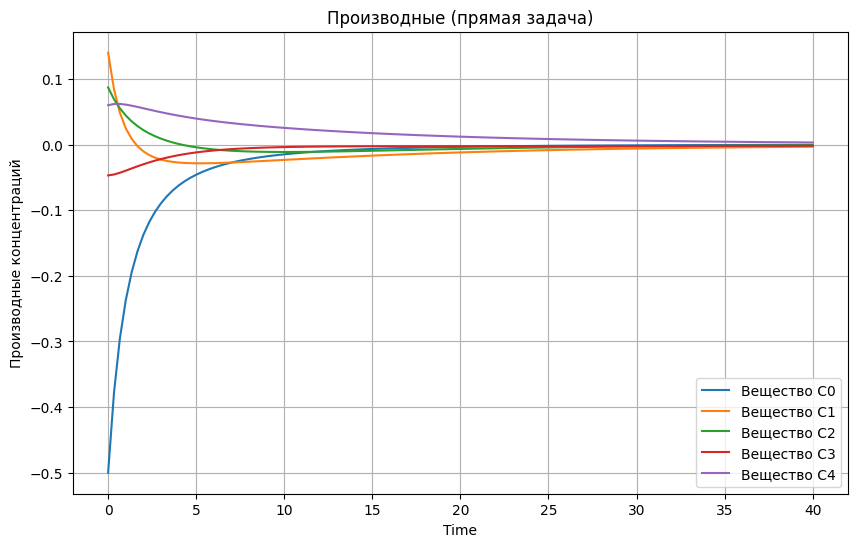

In [120]:
# Диапазон значений x
# x = np.linspace(0, 30, 61)    # Базово использовать tsteps

# Построение графиков
plt.figure(figsize=(10, 6))

for i in range(N_SUBSTANCE):
    plt.plot(tsteps, dCdt_TRUE[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (прямая задача)')
plt.legend()
plt.grid()
plt.show()


### Пародия (обратная задача)

In [121]:
def differentiate_polynomial(coefficients):
    degree = len(coefficients) # степень полинома + 1
    return np.array([coefficients[i] * i for i in range(1, degree)])

reaction_poly_derivatives = np.array([differentiate_polynomial(coeff) for coeff in reaction_poly_coeffs])

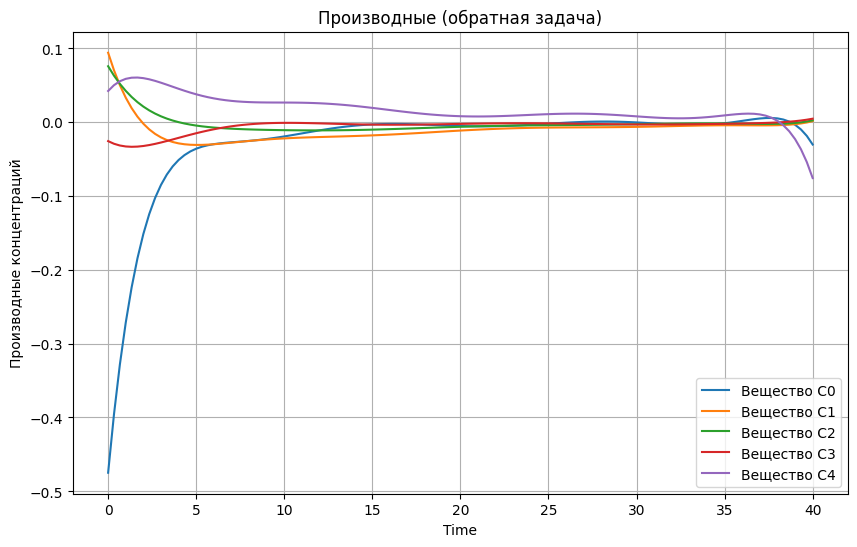

In [122]:
dCdt_predict = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, coeffs in enumerate(reaction_poly_derivatives):
    y = np.polyval(coeffs[::-1], tsteps)  # Вычисляем значения полинома
    dCdt_predict[i, :] = y

    # Вывод на график
    plt.plot(tsteps, dCdt_predict[i], label=f'Вещество C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные (обратная задача)')
plt.legend()
plt.grid()
plt.show()

### Производная от сплайнов

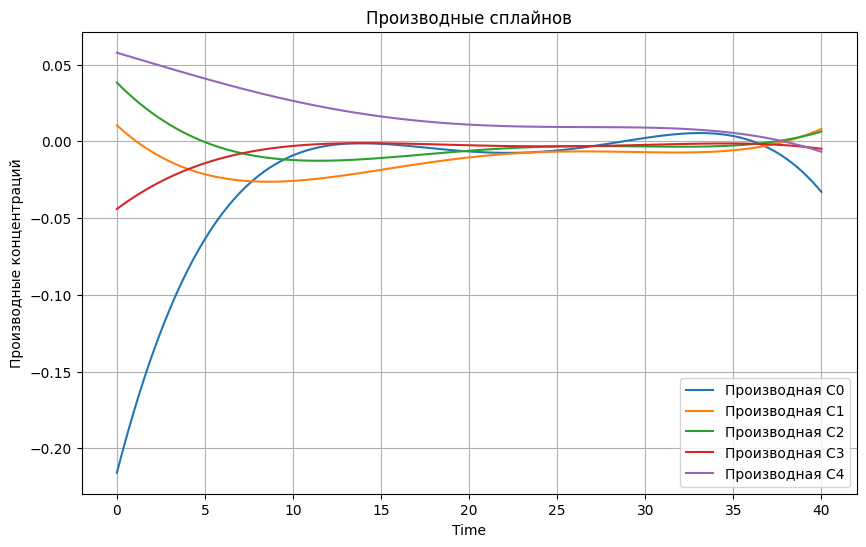

In [123]:
dCdt_spline = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, spl in enumerate(splines):
    y_deriv_pred = spl.derivative()(x_dense)  # Вычисляем значения производной
    dCdt_spline[i, :] = y_deriv_pred

    # Вывод на график
    plt.plot(x_dense, dCdt_spline[i], label=f'Производная C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные сплайнов')
plt.legend()
plt.grid()
plt.show()

### Производная по сплайнам с узлами

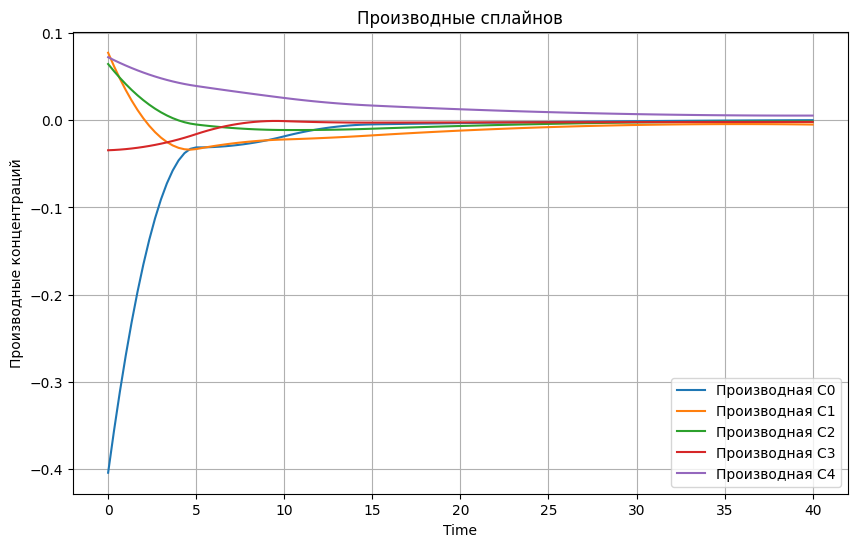

In [124]:
dCdt_spline_2 = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, spl in enumerate(splines_2):
    y_deriv_pred = spl.derivative()(x_dense)  # Вычисляем значения производной
    dCdt_spline_2[i, :] = y_deriv_pred

    # Вывод на график
    plt.plot(x_dense, dCdt_spline_2[i], label=f'Производная C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные сплайнов')
plt.legend()
plt.grid()
plt.show()

# Графики остатков производных

### От полиномов

In [125]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_predict[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1400,  # Ширина холста
    height=800   # Высота холста
)

fig.show()

### От сплайнов

In [126]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_spline[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1400,  # Ширина холста
    height=800   # Высота холста
)

fig.show()

### От сплайнов_2

In [127]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_spline_2[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1400,  # Ширина холста
    height=800   # Высота холста
)

fig.show()

# Вычисление k по данным обратной задачи

In [128]:
K_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # k по изначальным данным
k_poly = np.zeros((N_REACTION, len(tsteps)))                        # k по полиномам
k_spline = np.zeros((N_REACTION, len(tsteps)))                      # k по сплайнам
k_spline_2 = np.zeros((N_REACTION, len(tsteps)))                    # k по сплайнам_2


W_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # W(скорости реакций) по изначальным данным
W_poly = np.zeros((N_REACTION, len(tsteps)))                        # W по полиномам
W_spline = np.zeros((N_REACTION, len(tsteps)))                      # W по сплайнам
W_spline_2 = np.zeros((N_REACTION, len(tsteps)))                    # W по сплайнам_2


C_TRUE = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C(концентрации) по изначальным данным
C_poly = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C по полиномам
C_spline = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C по сплайнам
C_spline_2 = np.zeros((N_SUBSTANCE, len(tsteps)))                   # C по сплайнам_2


In [129]:
matrix_transformations = np.linalg.inv(MATR @ MATR.T) @ MATR

In [130]:
print(matrix_transformations)

[[-0.3125  0.375  -0.3125 -0.3125  0.0625]
 [-0.3125 -0.625   0.6875  0.6875  0.0625]
 [-0.25   -0.5    -0.25    0.75    0.25  ]
 [-0.1875 -0.375  -0.1875 -0.1875  0.4375]]


## k по полиномиальной аппроксимации

In [131]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_predict.T[i]
    C = np.array([np.polyval(substance[::-1], val) for substance in reaction_poly_coeffs])
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_poly[:, i] = W
    C_poly[:, i] = C
    k_poly[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)


## k по начальным данным

In [132]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_TRUE.T[i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_TRUE[:, i] = W
    C_TRUE[:, i] = C
    K_TRUE[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

# print(k_eval)


## k по сплайнам

In [133]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_spline.T[i]
    C = [float(splines[0](x_dense[i])), float(splines[1](x_dense[i])), float(splines[2](x_dense[i])), float(splines[3](x_dense[i])), float(splines[4](x_dense[i]))]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_spline[:, i] = W
    C_spline[:, i] = C
    k_spline[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)

## k по сплайнам_2

In [134]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_spline_2.T[i]
    C = [float(splines_2[0](x_dense[i])), float(splines_2[1](x_dense[i])), float(splines_2[2](x_dense[i])), float(splines_2[3](x_dense[i])), float(splines_2[4](x_dense[i]))]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_spline_2[:, i] = W
    C_spline_2[:, i] = C
    k_spline_2[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)

## Генерация k в ходе обратной задачи 

In [135]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Прямая', 'Полином'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=K_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_poly[i, :], 
        mode='lines', 
        name=f'Реакция {i} (полином)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


Скачки всё равно остаются, и чем дальше по времени, тем сильнее графики колбасит

In [136]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Прямая', 'Сплайн'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=K_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_spline_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (сплайн)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


# Test_1

## Генерация k в ходе обратной задачи 

In [137]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Полином', 'Сплайн'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_poly[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_spline_2[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


##

## Вывод интересных графиков

In [138]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-истинная', 'W-предсказанная'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_poly[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


W-скорости реакций предсказываются отрицательными. Они не должны быть отрицательными

In [139]:
colors = ['blue', 'red', 'green', 'purple','black']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['dCdt-истинная', 'dCdt-предсказанная'])

# Первый график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_SUBSTANCE):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_predict[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.3, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.3, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [140]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['k-истинная', 'k-предсказанная'])

# Первый график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=K_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_poly[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1700,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-1, 1], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()
